# Linear Models

## Overview 

This notebook contains an initial exploration of different linear regressions to predict monthly ED demand. 

For all models, variables used include:

- Service capacity (111, GP, Ambulance)
- Service utility (111, Ambulance)
- Population
- Population Health (People, Places, Lives)

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import OrthogonalMatchingPursuit as OMP

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]])
               if '/' in c else c for c in dta.columns]

In [5]:
dta.ccg.unique().shape

(74,)

## Add random feature

In [6]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [7]:
dta.shape

(1618, 14)

## Train test split 

In [8]:
train, test = train_test_split(dta,random_state=29)

In [9]:
y = dta['ae_attendances_attendances']
X = dta.drop(['ae_attendances_attendances','ccg','month'], axis=1)



y_train = train['ae_attendances_attendances'].values
X_train = train.drop(['ae_attendances_attendances','ccg','month'], axis=1)

y_test = test['ae_attendances_attendances'].values
X_test = test.drop(['ae_attendances_attendances','ccg','month'], axis=1)

## Ridge regression 

### No scaling 

In [10]:
model = Ridge()
#model = make_pipeline(StandardScaler(), RidgeCV())

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.5440194513191048
model score on testing data: 0.5336104269604207


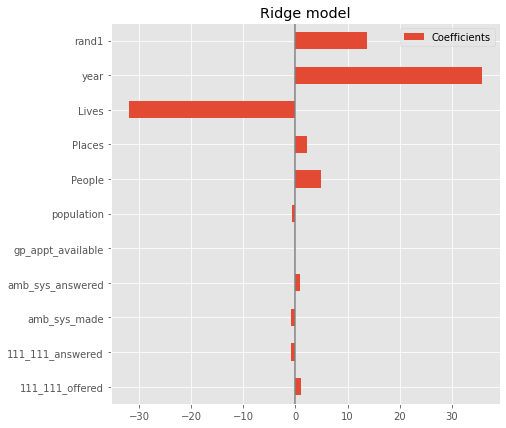

In [11]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Without scaling features it is not possible to compare their importance using model coefficients

### Standardise features 

In [12]:
model = make_pipeline(StandardScaler(), Ridge())

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.543812323234377
model score on testing data: 0.5336184653406383


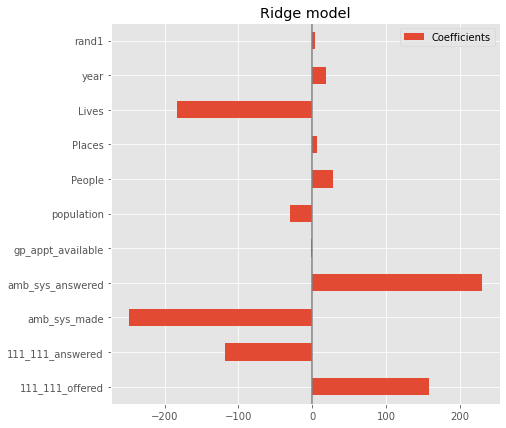

In [13]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### Feature selection 

In [14]:
selector = RFECV(model[1], step=1, cv=5)

selector = selector.fit(X_train, y_train)

In [15]:
support = pd.DataFrame(
   selector.support_,
   columns=['Support'], index=X_train.columns
)

In [16]:
support

,Support
111_111_offered,True
111_111_answered,True
amb_sys_made,True
amb_sys_answered,True
gp_appt_available,False
population,True
People,True
Places,True
Lives,True
year,True


The random variable should not be supported

### With cross-validation 

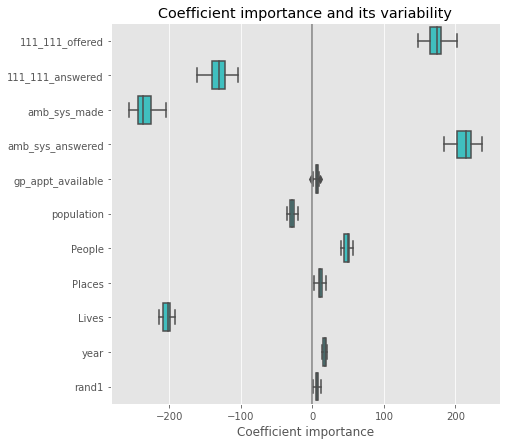

In [17]:
cv_model = cross_validate(
   model, X,y, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=0),
   return_estimator=True, n_jobs=2
)

coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X.columns
)

plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

## Lasso 

### Standardise Features 

In [18]:
model = make_pipeline(StandardScaler(), Lasso(alpha=.015, max_iter=100000))

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.5440180818857432
model score on testing data: 0.5335852489275236


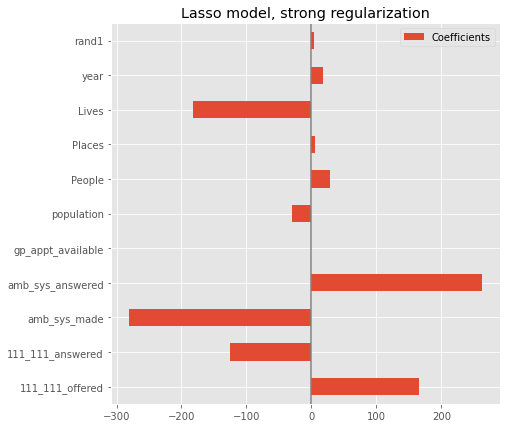

In [19]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Lasso model, strong regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### Feature selection 

In [20]:
selector = RFECV(model[1], step=1, cv=5)

selector = selector.fit(X_train, y_train)

In [21]:
support = pd.DataFrame(
   selector.support_,
   columns=['Support'], index=X_train.columns
)

In [22]:
support

,Support
111_111_offered,True
111_111_answered,True
amb_sys_made,True
amb_sys_answered,True
gp_appt_available,False
population,True
People,True
Places,True
Lives,True
year,True


### Cross validate 

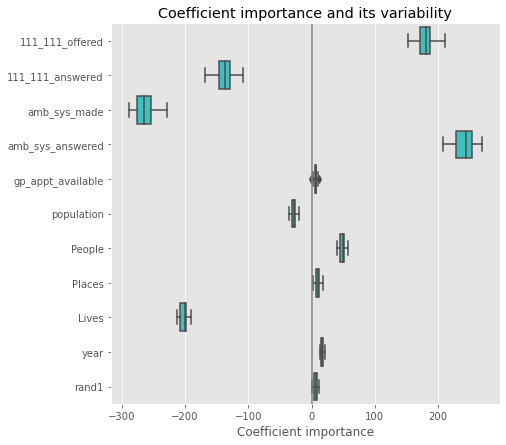

In [23]:
cv_model = cross_validate(
   model, X,y, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=0),
   return_estimator=True, n_jobs=2
)

coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X.columns
)
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

## OLS 

### Standardise Features

In [24]:
model = make_pipeline(StandardScaler(), LinearRegression())

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.5440195223174749
model score on testing data: 0.5336193991596547


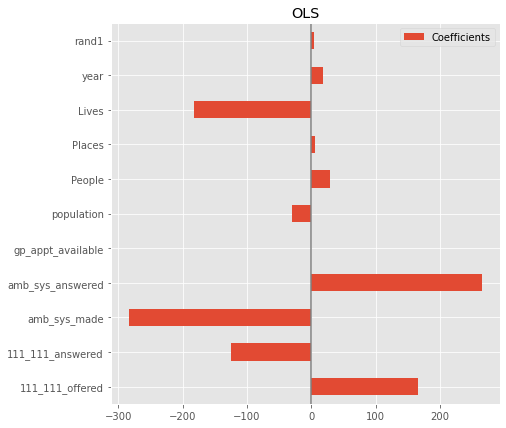

In [25]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('OLS')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### Feature selection 

In [26]:
selector = RFECV(model[1], step=1, cv=5)

selector = selector.fit(X_train, y_train)

In [27]:
support = pd.DataFrame(
   selector.support_,
   columns=['Support'], index=X_train.columns
)

In [28]:
support

,Support
111_111_offered,True
111_111_answered,True
amb_sys_made,True
amb_sys_answered,True
gp_appt_available,False
population,True
People,True
Places,True
Lives,True
year,True


### Cross validate 

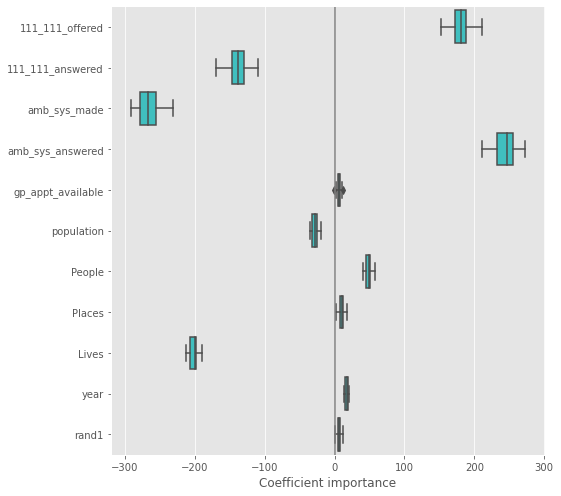

In [29]:
cv_model = cross_validate(
   model, X,y, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=0),
   return_estimator=True, n_jobs=2
)

coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X.columns
)
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
#plt.title('Coefficient importance and its variability')
plt.tight_layout()
plt.savefig('ols_feature_importance.pdf')
plt.subplots_adjust(left=.3)

## ElasticNet

### Standardise Features 

In [30]:
model = make_pipeline(StandardScaler(), 
                      ElasticNet(max_iter=100000))

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.4727309935289348
model score on testing data: 0.43772822174451687


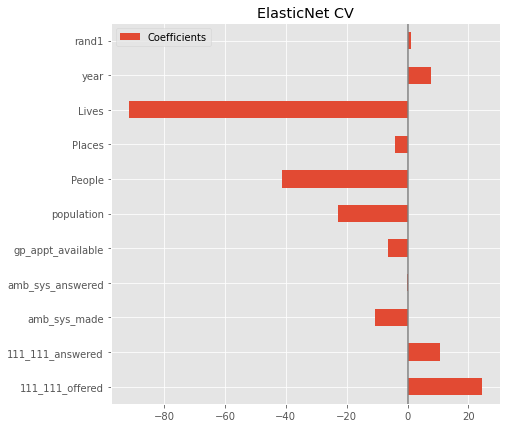

In [31]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('ElasticNet CV')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### Cross validate 

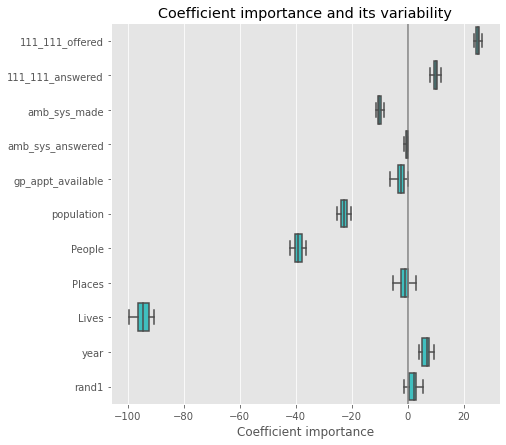

In [32]:
cv_model = cross_validate(
   model, X,y, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=0),
   return_estimator=True, n_jobs=2
)

coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X.columns
)
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

## Feature Selection 

### OMP 

In [33]:
model = make_pipeline(StandardScaler(), 
                      OMP(n_nonzero_coefs = 2, normalize=False))

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')


model score on training data: 0.4992217993534437
model score on testing data: 0.4823928451338607


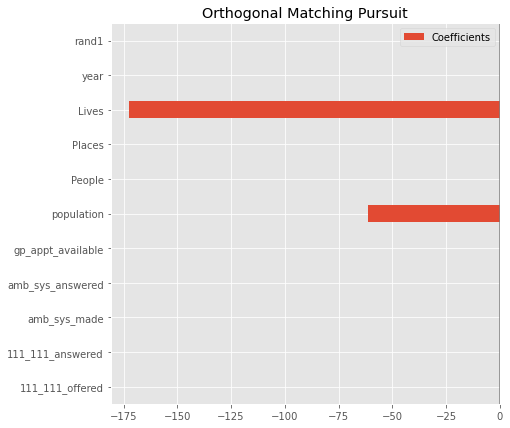

In [34]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Orthogonal Matching Pursuit')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

#### Score vs n_feat 

In [35]:
num_features = [i+1 for i in range(X.shape[1])]

results_train, results_test = pd.DataFrame(), pd.DataFrame()

for k in num_features:

    
    model = make_pipeline(StandardScaler(), 
                          OMP(n_nonzero_coefs = k, normalize=False))


    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_train, scores_test = [],[]
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))

    results_test[k]=scores_test
    results_train[k]=scores_train

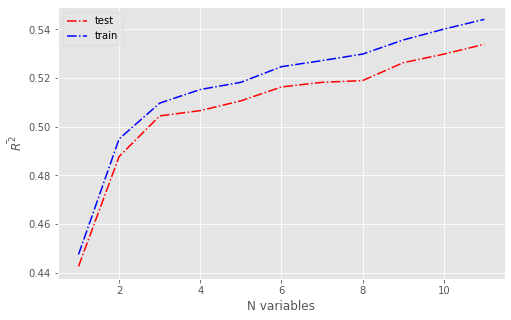

In [36]:
fig = plt.figure(figsize=(8,5))

plt.plot(num_features, results_test.mean(), 'r-.', label='test')
plt.plot(num_features, results_train.mean(), 'b-.', label='train')

plt.xlabel('N variables')
plt.ylabel(r'$\bar{R^2}$')
plt.legend(loc='best')
#plt.savefig('rsq_features_omp.pdf')
plt.show()

### LARS 

In [37]:
from sklearn.linear_model import Lars

model = make_pipeline(StandardScaler(), 
                      Lars(n_nonzero_coefs = X.shape[1], normalize=False))

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')


model score on training data: 0.5440195223174749
model score on testing data: 0.533619399159655


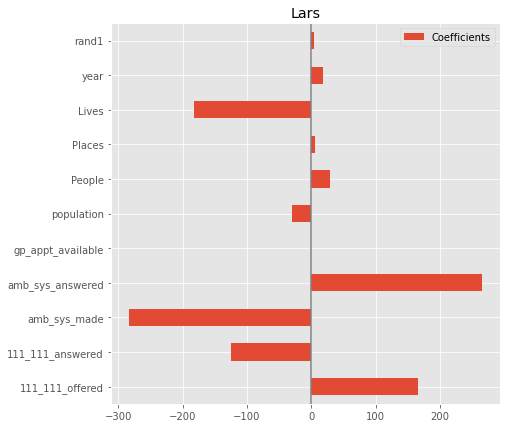

In [38]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Lars')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

#### Score vs number of features

In [39]:
num_features = [i+1 for i in range(X.shape[1])]

results_train, results_test = pd.DataFrame(), pd.DataFrame()

for k in num_features:
    
    model = make_pipeline(StandardScaler(), 
                          Lars(n_nonzero_coefs = k, normalize=False))


    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_train, scores_test = [],[]
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))

    results_test[k]=scores_test
    results_train[k]=scores_train

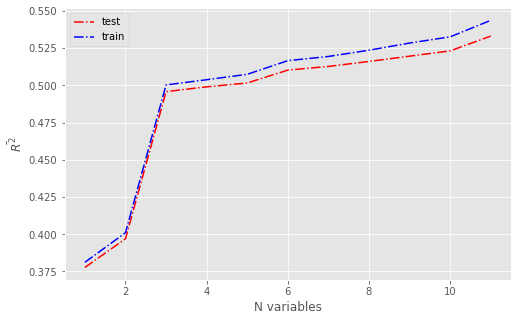

In [40]:
fig = plt.figure(figsize=(8,5))

plt.plot(num_features, results_test.mean(), 'r-.', label='test')
plt.plot(num_features, results_train.mean(), 'b-.', label='train')

plt.xlabel('N variables')
plt.ylabel(r'$\bar{R^2}$')
plt.legend(loc='best')
#plt.savefig('rsq_features_lars.pdf')
plt.show()

### Mutual information 

In [41]:
mi = mutual_info_regression(X_train,y_train)

In [42]:
mi_df = pd.DataFrame(
   mi,
   columns=['Mutual Information'], index=X_train.columns
)

mi_df

,Mutual Information
111_111_offered,0.368889
111_111_answered,0.342691
amb_sys_made,0.618272
amb_sys_answered,0.716384
gp_appt_available,0.087838
population,1.394764
People,1.275716
Places,1.387013
Lives,1.317528
year,0.032590


#### Cross validated 

In [43]:
num_features = [i+1 for i in range(X.shape[1])]

results_train, results_test = pd.DataFrame(), pd.DataFrame()

for k in num_features:
    
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    
    model = make_pipeline(fs, LinearRegression())
    
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_train, scores_test = [],[]
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))

    results_test[k]=scores_test
    results_train[k]=scores_train

    print('>%d %.3f (%.3f)' % (k, np.mean(scores_test), np.std(scores_test)))

>1 0.077 (0.086)


>2 0.165 (0.066)


>3 0.496 (0.036)


>4 0.501 (0.035)


>5 0.502 (0.035)


>6 0.509 (0.035)


>7 0.524 (0.034)


>8 0.531 (0.033)


>9 0.531 (0.033)


>10 0.534 (0.034)


>11 0.534 (0.035)


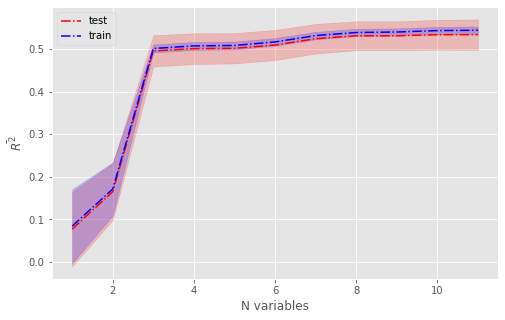

In [44]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(num_features, results_test.mean(), 'r-.', label='test')
plt.plot(num_features, results_train.mean(), 'b-.', label='train')

plt.fill_between(num_features, y1=(results_test.mean()-results_test.std()).values, 
                 y2=(results_test.mean()+results_test.std()).values,  alpha=0.2, color='r')

plt.fill_between(num_features, y1=results_train.mean()-results_train.std(), 
                 y2=results_train.mean()+results_train.std(), alpha=0.2, color='b')

plt.xlabel('N variables')
plt.ylabel(r'$\bar{R^2}$')
plt.legend(loc='best')

#plt.savefig('rsq_features_mi.pdf')
plt.show()

#### Average importance 

In [45]:
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X,y)

mi_df = pd.DataFrame(
   fs.scores_,
   columns=['Scores'], index=X.columns
)

mi_df.sort_values(by='Scores', ascending=False)

,Scores
Places,1.436297
population,1.436055
Lives,1.391061
People,1.351514
amb_sys_answered,0.692218
amb_sys_made,0.628977
111_111_offered,0.383233
111_111_answered,0.338584
gp_appt_available,0.096549
year,0.021728


## Summary 

Models perform comparatively well, with an $R^2$ of ~ 0.56

The random feature is supported when using recursive feature elimination

When using the mutual information score, the random feature is excluded. Population and measures of population health are most important.

Mutual information accounts for non-linear relationships, suggesting a non-linear model may be more appropriate.